# **Seminar - Attention и Transformer**

## 1. Let's build Transformer from scratch in Pytorch

<img src="https://i.pinimg.com/736x/c1/83/1a/c1831a58ecc935fc0f2ef4d35ce4fddb.jpg">

In [ ]:
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Multi-head Attention

#### Main class - MultiHeadAttention

**Initialization:**
* _in_size_ ~ size of the input embeddings
* _head_size_ ~ size of the embeddings for Q, K, V matrices after transformation
* _num_heads_ ~ number of heads
* _out_size_ ~ size of the output embeddings
* _query_in_size_ ~ size of the input embeddings

**Forward:**
* query, key, value ~ 3 tensors (one for each Q, K, and V transformation - these are not yet the tensors of shape $\text{batch_size} \times seq \times d_k$, but tensors of shape $\text{batch_size} \times seq \times \text{in_size}$)
* mask ~ boolean mask for Masked Multi-head Attention (in the decoder)

$$ Attention(Q, K, V) = softmax\Bigg(\frac{QK^T}{\sqrt{d_k}}\Bigg) \cdot V $$
$$ MultiHead(Q, K, V) = Concat(head_1, ..., head_H) \cdot W^O \quad ; \quad head_i = Attention(Q W_i^Q, K W_i^K, V W_i^V)$$

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Class to calculate Multi-head attention (or Masked Multi-head attention for the decoder) operation
    """
    def __init__(self, in_size, head_size, num_heads, out_size, query_in_size=None):
        """
        Args:
            in_size: embedding size of input
            head_size: hidden size of Q, K, V matrices
            num_heads: number of heads
            out_size: output embedding size
            query_in_size: embedding size of input for query (if not provided - same as in_size)
        """
        super(MultiHeadAttention, self).__init__()

        # Store all passed layer hyperparameters
        self.in_size = in_size
        self.head_size = head_size
        self.num_heads = num_heads
        self.out_size = out_size
        self.query_in_size = self.in_size if query_in_size is None else query_in_size

        # Linear transformations for Q, K, V matrices (get all Q, K, V matrices directly)
        self.query_matrix = nn.Linear(self.query_in_size, self.num_heads * self.head_size, bias=False)
        self.key_matrix = nn.Linear(self.in_size, self.num_heads * self.head_size, bias=False)
        self.value_matrix = nn.Linear(self.in_size, self.num_heads * self.head_size, bias=False)
        # Linear transformation for concatenating heads
        self.out = nn.Linear(self.head_size * self.num_heads, self.out_size)

    def forward(self, query, key, value, mask=None):
        """
        Args:
           query : tensor for query
           key : tensor for key
           value : tensor for value
           mask: mask for the decoder

        Returns:
           output vector from multihead attention
        """
        # Tensors come with the shape batch_size x seq_len x in_size
        batch_size = key.size(0)
        seq_len = key.size(1)

        # The number of tokens in the query will differ for the decoder
        query_seq_len = query.size(1)

        # Apply linear transformations to the input
        q = self.query_matrix(query)  # (batch_size, query_seq_len, head_size * num_heads)
        k = self.key_matrix(key)  # (batch_size, seq_len, head_size * num_heads)
        v = self.value_matrix(value)  # (batch_size, seq_len, head_size * num_heads)

        q = q.view(batch_size, query_seq_len, self.num_heads, self.head_size).transpose(1,2)  # (batch_size, num_heads, query_seq_len, head_size)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1,2)  # (batch_size, num_heads, seq_len, head_size)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_size).transpose(1,2)  # (batch_size, num_heads, seq_len, head_size)

        # Считаем релевантность
        relevance = q @ k.transpose(2, 3) / math.sqrt(self.head_size)  # (batch_size, num_heads, query_seq_len, seq_len)

        # Если есть маска (для декодера), то заполняем значения по маске как минус бесконечность (чтобы exp(r) = 0 в softmax)
        if mask is not None:
             relevance = relevance.masked_fill(mask, -torch.inf)

        # Получаем вероятности
        relevance = F.softmax(relevance, dim=-1)

        # Считаем выходы из каждой головы
        head_i = torch.matmul(relevance, v)  # (batch_size, num_heads, query_seq_len, head_size)

        # Конкатенируем выходы
        concat = head_i.transpose(1,2).reshape(batch_size, query_seq_len, self.head_size * self.num_heads)  # (batch_size, query_seq_len, num_heads * head_size)

        return self.out(concat)  # (batch_size, query_seq_len, out_size)

#### Testing MultiHeadAttention for the encoder

In [ ]:
tmp_layer = MultiHeadAttention(
    in_size=10,
    head_size=4,
    num_heads=3,
    out_size=15,
)

tmp_layer

MultiHeadAttention(
  (query_matrix): Linear(in_features=10, out_features=12, bias=False)
  (key_matrix): Linear(in_features=10, out_features=12, bias=False)
  (value_matrix): Linear(in_features=10, out_features=12, bias=False)
  (out): Linear(in_features=12, out_features=15, bias=True)
)

In [ ]:
# Check in normal forward pass from the encoder
tmp_input = torch.rand(2, 5, 10)

print("Encoder-like input, no mask")
print(f'Input shape: {tmp_input.shape}')
tmp_output = tmp_layer(tmp_input, tmp_input, tmp_input)
print(f'Output shape: {tmp_output.shape}')

del tmp_input, tmp_output

Encoder-like input, no mask
Input shape: torch.Size([2, 5, 10])
Output shape: torch.Size([2, 5, 15])


#### Testing MultiHeadAttention for a mixture of encoder and decoder

In [ ]:
tmp_layer = MultiHeadAttention(
    in_size=10,
    head_size=4,
    num_heads=3,
    out_size=15,
    query_in_size=12,
)

tmp_layer

MultiHeadAttention(
  (query_matrix): Linear(in_features=12, out_features=12, bias=False)
  (key_matrix): Linear(in_features=10, out_features=12, bias=False)
  (value_matrix): Linear(in_features=10, out_features=12, bias=False)
  (out): Linear(in_features=12, out_features=15, bias=True)
)

In [ ]:
# Check forward pass in the decoder, where we mix information from the encoder and decoder
tmp_input_q = torch.rand(2, 5, 12)
tmp_input_kv = torch.rand(2, 7, 10)

print("Encoder+Decoder-like input, no mask")
print(f'Input Q shape: {tmp_input_q.shape}')
print(f'Input KV shape: {tmp_input_kv.shape}')

tmp_output = tmp_layer(tmp_input_q, tmp_input_kv, tmp_input_kv)
print(f'Output shape: {tmp_output.shape}')

del tmp_input_q, tmp_input_kv, tmp_output

Encoder+Decoder-like input, no mask
Input Q shape: torch.Size([2, 5, 12])
Input KV shape: torch.Size([2, 7, 10])
Output shape: torch.Size([2, 5, 15])


#### Triangular Mask in the decoder

In [ ]:
def make_decoder_mask(decoder_embed):
    """
    Make mask for decoder Masked Multi-head Attention based on input sequence
    Args:
        decoder_embed: decoder sequence after embed
    Returns:
        mask: mask for Masked Multi-head Attention
    """
    batch_size, decoder_seq_len, _ = decoder_embed.shape
    mask = torch.tril(torch.ones((decoder_seq_len, decoder_seq_len))).expand(
        batch_size, 1, decoder_seq_len, decoder_seq_len
    ).bool()
    return mask

#### Testing MultiHeadAttention for the decoder with a mask

Mask shape: torch.Size([1, 1, 10, 10])


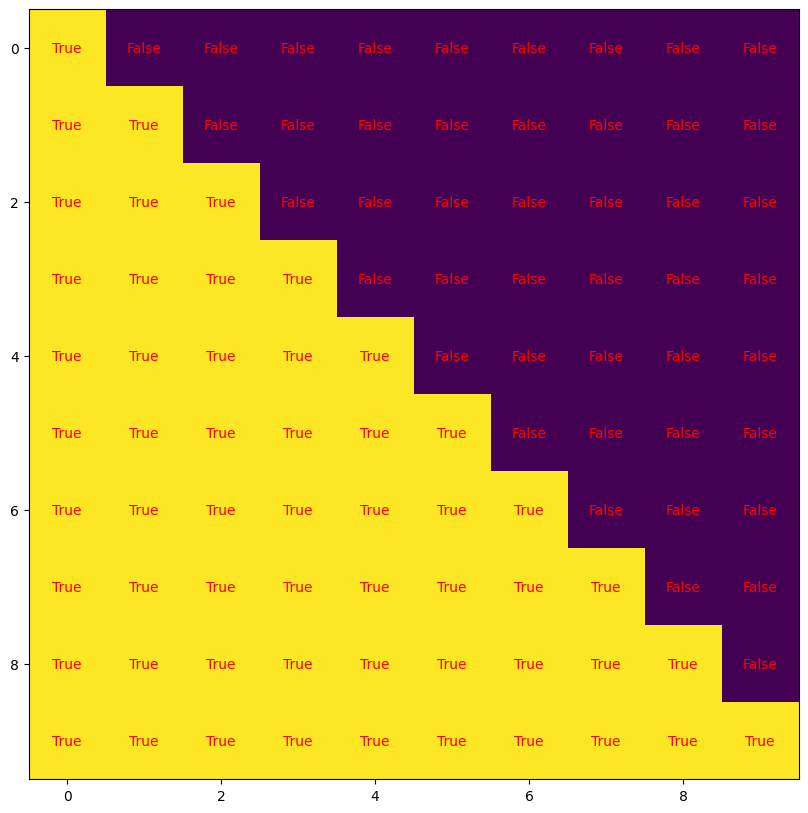

In [ ]:
tmp_input = torch.rand(1, 10, 256)
tmp_mask = make_decoder_mask(tmp_input)
print(f"Mask shape: {tmp_mask.shape}")

# Visualize the mask
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(tmp_mask[0, 0, :, :])

# Add text labels
for i in range(tmp_mask.shape[-2]):
    for j in range(tmp_mask.shape[-1]):
        text = plt.text(j, i, tmp_mask[0, 0, i, j].item(), ha="center", va="center", color="red")
plt.show()

In [ ]:
tmp_layer = MultiHeadAttention(
    in_size=10,
    head_size=4,
    num_heads=3,
    out_size=15,
)

tmp_layer

MultiHeadAttention(
  (query_matrix): Linear(in_features=10, out_features=12, bias=False)
  (key_matrix): Linear(in_features=10, out_features=12, bias=False)
  (value_matrix): Linear(in_features=10, out_features=12, bias=False)
  (out): Linear(in_features=12, out_features=15, bias=True)
)

In [ ]:
tmp_input = torch.rand(2, 5, 10)
tmp_mask = make_decoder_mask(tmp_input)

print("Decoder-like input, with mask")
print(f'Input shape: {tmp_input.shape}')
print(f'Mask shape: {tmp_mask.shape}')

tmp_output = tmp_layer(tmp_input, tmp_input, tmp_input, tmp_mask)
print(f'Output shape: {tmp_output.shape}')

del tmp_input, tmp_mask, tmp_output

Decoder-like input, with mask
Input shape: torch.Size([2, 5, 10])
Mask shape: torch.Size([2, 1, 5, 5])
Output shape: torch.Size([2, 5, 15])


### 1.2 Positional Encoding

#### Main class - PositionalEncoding

**Initialization:**
* max_seq_len ~ the maximum token length of the sequence
* emb_size ~ the embedding size of the input

**Forward:**
* _decoder_emb_ ~ embeddings of tokens from the decoder input

$$\text{PE}_{(\text{pos}, 2i)} = sin\Bigg( \frac{\text{pos}}{10000^{\frac{2i}{\text{emb_size}}}} \Bigg) \quad ; \quad \text{PE}_{(\text{pos}, 2i + 1)} = cos\Bigg( \frac{\text{pos}}{10000^{\frac{2i}{\text{emb_size}}}} \Bigg)$$

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Class to calculate Positional Encodings, suggested in `Attention is all you need [Vaswaniet al., 2017]`
    """
    def __init__(self, max_seq_len, emb_size):
        """
        Args:
            max_seq_len: max length of input sequence
            emb_size: demension of embedding
        """
        super(PositionalEncoding, self).__init__()

        # Запишем все переданые гиперпараметры слоя
        self.max_seq_len = max_seq_len
        self.emb_size = emb_size

        # Посчитаем позиционные эмбеддинги в тензорном виде
        pos = torch.arange(max_seq_len)[:, None]
        inds = torch.arange(emb_size)[None, ::2]

        pe = torch.zeros(max_seq_len, self.emb_size)
        pe[:, ::2] = torch.sin(pos / (10000 ** ((2 * inds) / self.emb_size)))
        pe[:, 1::2] = torch.cos(pos / (10000 ** ((2 * inds) / self.emb_size)))
        pe = pe.unsqueeze(0)

        # Добавляем полученный тензор как параметр, который будет сохранятся вместе с моделью, но не будет обучаться
        self.register_buffer('pe', pe)


    def forward(self, decoder_emb):
        """
        Args:
            decoder_emb: decoder sequence after embed
        Returns:
            output: input with positional encodings
        """
        # Тензоры приходят размера batch_size x seq_len x emb_size
        seq_len = decoder_emb.size(1)

        # Прибавляем позиционные эмбеддинги
        return decoder_emb + self.pe[:, :seq_len]

#### Testing PositionalEncoding

In [ ]:
tmp_layer = PositionalEncoding(
    max_seq_len=5,
    emb_size=10,
)

tmp_layer

PositionalEncoding()

In [ ]:
tmp_input = torch.rand(2, 5, 10)

print(f'Input shape: {tmp_input.shape}')
tmp_output = tmp_layer(tmp_input)
print(f'Output shape: {tmp_output.shape}')

del tmp_input, tmp_output

Input shape: torch.Size([2, 5, 10])
Output shape: torch.Size([2, 5, 10])


#### Let’s examine the positional encodings.

In [ ]:
tmp_layer.pe.shape

torch.Size([1, 5, 10])

the article substantiates [Attention is all you need [Vaswaniet al., 2017]](https://www.semanticscholar.org/reader/204e3073870fae3d05bcbc2f6a8e263d9b72e776):

We chose this function because we hypothesized it would allow the model to easily learn to attend by
relative positions, since for any fixed offset k, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

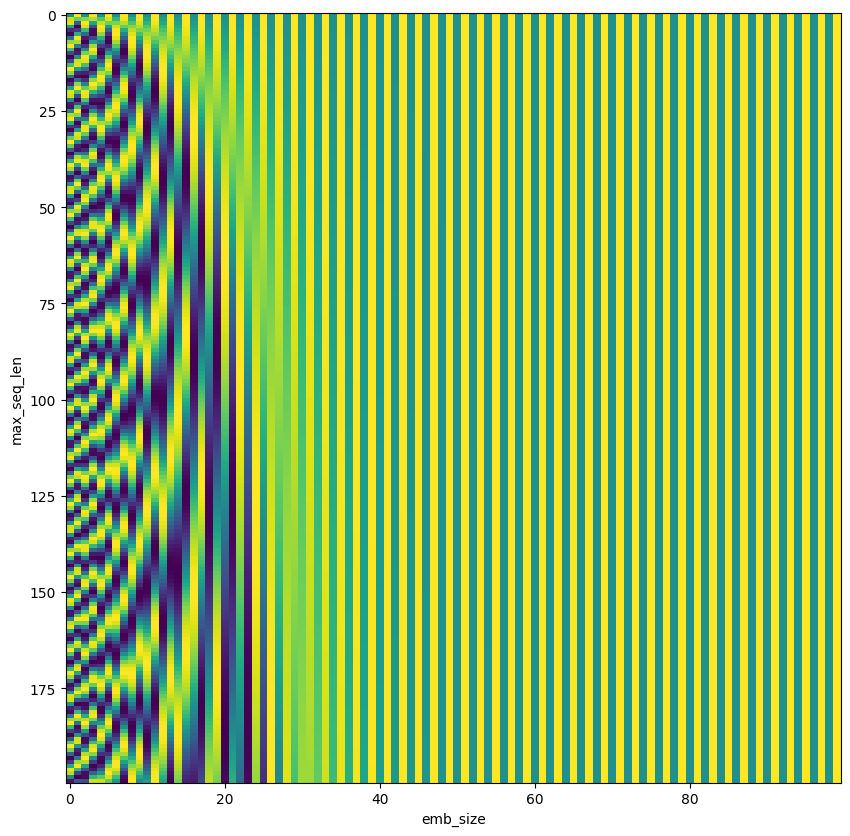

In [ ]:
tmp_layer = PositionalEncoding(
    max_seq_len=200,
    emb_size=100,
)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(tmp_layer.pe[0, :, :], aspect="auto")
plt.xlabel("emb_size")
plt.ylabel("max_seq_len")
plt.show()

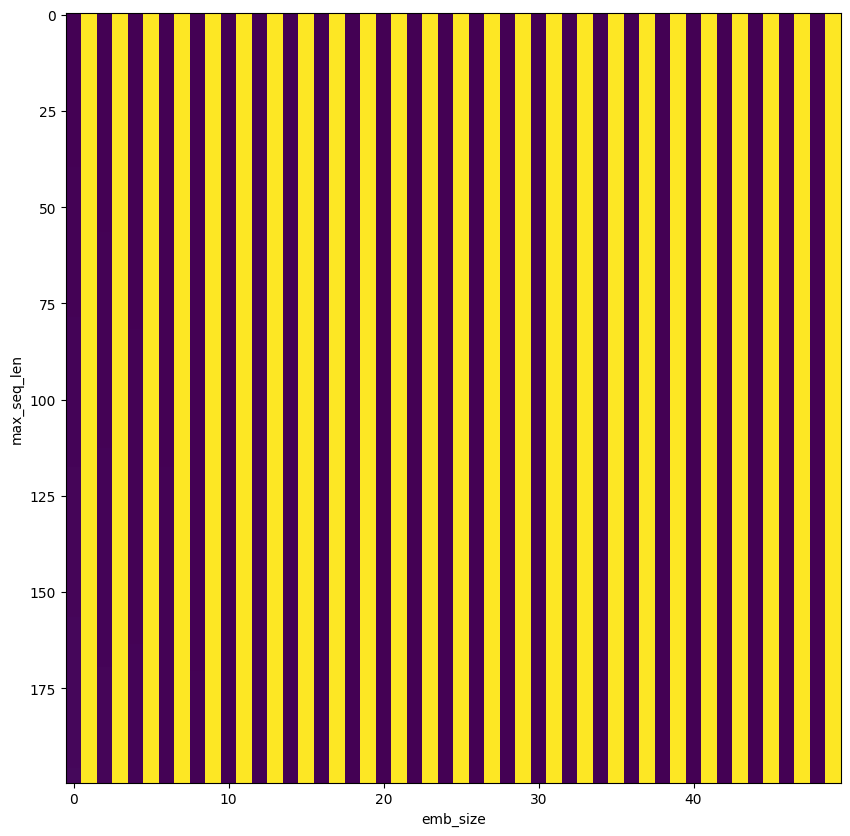

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(tmp_layer.pe[0, :, 50:], aspect="auto")
plt.xlabel("emb_size")
plt.ylabel("max_seq_len")
plt.show()

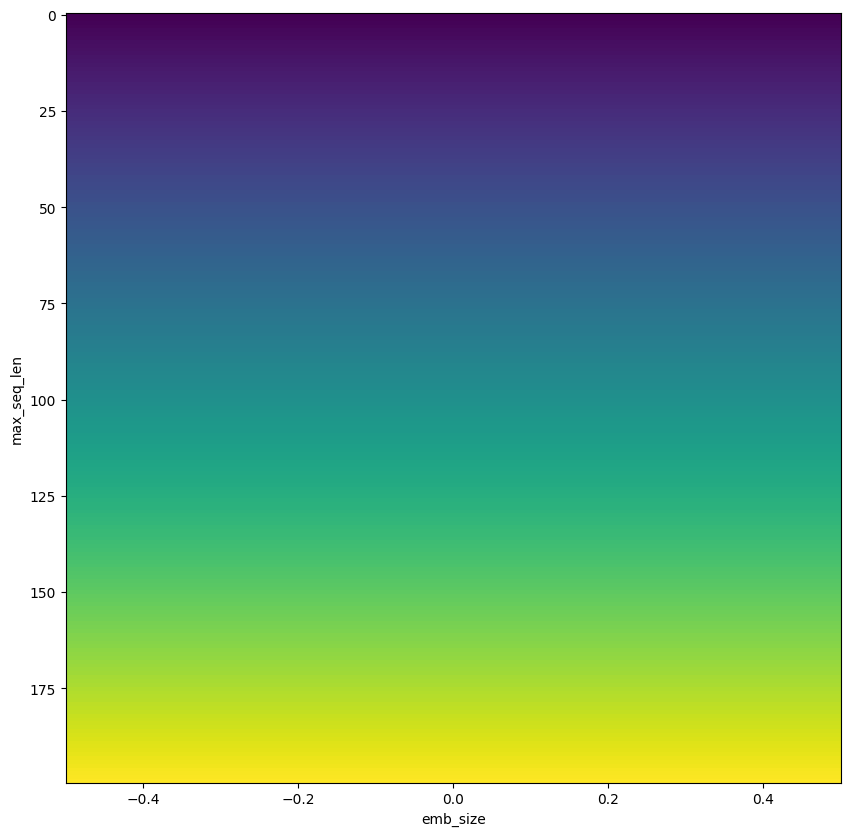

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(tmp_layer.pe[0, :, 50:51], aspect="auto")
plt.xlabel("emb_size")
plt.ylabel("max_seq_len")
plt.show()

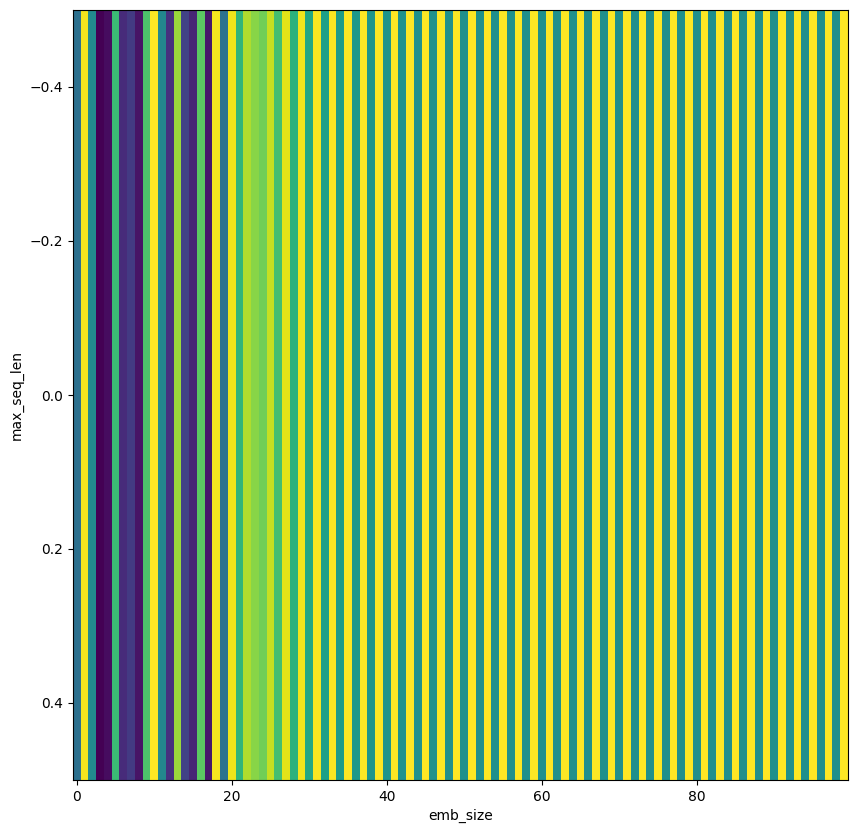

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(tmp_layer.pe[0, 50:51, :], aspect="auto")
plt.xlabel("emb_size")
plt.ylabel("max_seq_len")
plt.show()

### 1.3 Encoder

#### Picture

<img src="https://www.researchgate.net/profile/Ehsan-Amjadian/publication/352239001/figure/fig1/AS:1033334390013952@1623377525434/Detailed-view-of-a-transformer-encoder-block-It-first-passes-the-input-through-an.jpg" width=500>

#### TransformerEncoderBlock

**Initialization:**

* in_size ~ input embedding size
* head_size ~ size of the Q, K, V matrices embeddings after transformation
* num_heads ~ number of attention heads
* out_size ~ output embedding size for attention and the block
* ff_hidden_size ~ hidden size for feed-forward layers
* dropout_p ~ dropout probability
* query_in_size ~ input embedding size for the query (if None, defaults to in_size)

Forward:

*query, key, value ~ 3 tensors (one for each Q, K, and V transformation - these are not yet the tensors $\text{batch_size} \times seq \times d_k$, but tensors of shape $\text{batch_size} \times seq \times \text{in_size}$)

In [ ]:
class TransformerEncoderBlock(nn.Module):
    """
    Class with one full block within transformer's encoder
    """
    def __init__(self, in_size, head_size, num_heads, out_size, ff_hidden_size, dropout_p=0.2, query_in_size=None):
        """
        Args:
           in_size: input embedding size
           head_size: size of each attention head
           num_heads: number of attention heads
           out_size: output embedding size
           ff_hidden_size: hidden size for feed forward net
           dropout_p: probability for dropout
           query_in_size: embedding size of input for query (if not provided - same as in_size)
        """
        super(TransformerEncoderBlock, self).__init__()

        # Запишем все переданые гиперпараметры слоя
        self.in_size = in_size
        self.head_size = head_size
        self.num_heads = num_heads
        self.out_size = out_size
        self.ff_hidden_size = ff_hidden_size
        self.dropout_p = dropout_p
        self.query_in_size = in_size if query_in_size is None else query_in_size

        self.attention = MultiHeadAttention(self.in_size, self.head_size, self.num_heads, self.out_size, self.query_in_size)
        # Если выход и вход attention-а имеют разный размер, то используем линейный слой на residual connection-е
        self.adapt_residual = nn.Linear(self.query_in_size, self.out_size) if self.query_in_size != self.out_size else nn.Identity()

        self.norm_1 = nn.LayerNorm(self.out_size)
        self.dropout_1 = nn.Dropout(self.dropout_p)

        self.feed_forward = nn.Sequential(OrderedDict([
            ("lin_1", nn.Linear(self.out_size, self.ff_hidden_size)),
            ("act", nn.ReLU()),
            ("lin_2", nn.Linear(self.ff_hidden_size, self.out_size)),
        ]))

        self.norm_2 = nn.LayerNorm(self.out_size)
        self.dropout_2 = nn.Dropout(self.dropout_p)


    def forward(self, query, key, value):
        """
        Args:
           block_input: input to corresponding block
        """
        # Получаем на вход 3 тензора batch_size x seq_len x in_size
        attention_out = self.attention(query, key, value)  # (batch_size, seq_len, out_size)
        attention_residual_out = attention_out + self.adapt_residual(query)
        norm_1_out = self.dropout_1(self.norm_1(attention_residual_out))

        # (batch_size, seq_len, out_size) -> (batch_size, seq_len, ff_hidden_size) -> (batch_size, seq_len, out_size)
        ff_out = self.feed_forward(norm_1_out)
        ff_residual_out = ff_out + norm_1_out
        return self.dropout_2(self.norm_2(ff_residual_out))

#### Testing TransformerEncoderBlock for the encoder

In [ ]:
# We check the standard forward pass from the encoder
tmp_layer = TransformerEncoderBlock(
    in_size=10,
    head_size=7,
    num_heads=2,
    out_size=15,
    ff_hidden_size=20,
    dropout_p=0.1,
)

tmp_layer

TransformerEncoderBlock(
  (attention): MultiHeadAttention(
    (query_matrix): Linear(in_features=10, out_features=14, bias=False)
    (key_matrix): Linear(in_features=10, out_features=14, bias=False)
    (value_matrix): Linear(in_features=10, out_features=14, bias=False)
    (out): Linear(in_features=14, out_features=15, bias=True)
  )
  (adapt_residual): Linear(in_features=10, out_features=15, bias=True)
  (norm_1): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (dropout_1): Dropout(p=0.1, inplace=False)
  (feed_forward): Sequential(
    (lin_1): Linear(in_features=15, out_features=20, bias=True)
    (act): ReLU()
    (lin_2): Linear(in_features=20, out_features=15, bias=True)
  )
  (norm_2): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (dropout_2): Dropout(p=0.1, inplace=False)
)

In [ ]:
tmp_input = torch.rand(2, 5, 10)

print("Encoder-like input")
print(f'Input shape: {tmp_input.shape}')
tmp_output = tmp_layer(tmp_input, tmp_input, tmp_input)
print(f'Output shape: {tmp_output.shape}')

del tmp_input, tmp_output

Encoder-like input
Input shape: torch.Size([2, 5, 10])
Output shape: torch.Size([2, 5, 15])


#### Testing TransformerEncoderBlock for the decoder

In [ ]:
tmp_layer = TransformerEncoderBlock(
    in_size=10,
    head_size=7,
    num_heads=2,
    out_size=15,
    ff_hidden_size=20,
    dropout_p=0.1,
    query_in_size=12,
)

tmp_layer

TransformerEncoderBlock(
  (attention): MultiHeadAttention(
    (query_matrix): Linear(in_features=12, out_features=14, bias=False)
    (key_matrix): Linear(in_features=10, out_features=14, bias=False)
    (value_matrix): Linear(in_features=10, out_features=14, bias=False)
    (out): Linear(in_features=14, out_features=15, bias=True)
  )
  (adapt_residual): Linear(in_features=12, out_features=15, bias=True)
  (norm_1): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (dropout_1): Dropout(p=0.1, inplace=False)
  (feed_forward): Sequential(
    (lin_1): Linear(in_features=15, out_features=20, bias=True)
    (act): ReLU()
    (lin_2): Linear(in_features=20, out_features=15, bias=True)
  )
  (norm_2): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (dropout_2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# We check the forward pass from the decoder, where we mix information from the encoder and decoder.

In [ ]:
tmp_input_q = torch.rand(2, 5, 12)
tmp_input_kv = torch.rand(2, 7, 10)

print("Encoder+Decoder-like input")
print(f'Input Q shape: {tmp_input_q.shape}')
print(f'Input KV shape: {tmp_input_kv.shape}')

tmp_output = tmp_layer(tmp_input_q, tmp_input_kv, tmp_input_kv)
print(f'Output shape: {tmp_output.shape}')

del tmp_input_q, tmp_input_kv, tmp_output

Encoder+Decoder-like input
Input Q shape: torch.Size([2, 5, 12])
Input KV shape: torch.Size([2, 7, 10])
Output shape: torch.Size([2, 5, 15])


#### TransformerEncoder

**Initialization:**

* max_seq_len ~ maximum sequence length in tokens
* vocab_size ~ vocabulary size
* emb_size ~ input embedding size
* num_layers ~ number of TransformerEncoderBlocks
* att_out_size ~ output embedding size from attention and the block
* att_head_size ~ embedding size of Q, K, V matrices after transformation
* num_heads ~ number of attention heads
* ff_hidden_size ~ hidden size for the feed-forward layers
* dropout_p ~ dropout probability

**Forward:**

* encoder_input ~ tokens input to the encoder before embedding

In [ ]:
class TransformerEncoderBlock(nn.Module):
    """
    Class with one full block within transformer's encoder
    """
    def __init__(self, in_size, head_size, num_heads, out_size, ff_hidden_size, dropout_p=0.2, query_in_size=None):
        """
        Args:
           in_size: input embedding size
           head_size: size of each attention head
           num_heads: number of attention heads
           out_size: output embedding size
           ff_hidden_size: hidden size for feed-forward net
           dropout_p: probability for dropout
           query_in_size: embedding size for the query input (if not provided, use in_size)
        """
        super(TransformerEncoderBlock, self).__init__()

        # Store all passed layer hyperparameters
        self.in_size = in_size
        self.head_size = head_size
        self.num_heads = num_heads
        self.out_size = out_size
        self.ff_hidden_size = ff_hidden_size
        self.dropout_p = dropout_p
        self.query_in_size = in_size if query_in_size is None else query_in_size

        self.attention = ...
        self.adapt_residual = ...

        self.norm_1 = ...
        self.dropout_1 = ...

        self.feed_forward = nn.Sequential(OrderedDict([
            ("lin_1", ...),
            ("act", ...),
            ("lin_2", ...),
        ]))

        self.norm_2 = ...
        self.dropout_2 = ...


    def forward(self, query, key, value):
        """
        Args:
           block_input: input to corresponding block
        """
        # Input of 3 tensors batch_size x seq_len x in_size
        attention_out = ...
        attention_residual_out = ...
        norm_1_out = ...

        ff_out = ...
        ff_residual_out = ...
        norm_2_out = ...
        return norm_2_out

#### Testing TransformerEncoder

In [ ]:
tmp_layer = TransformerEncoder(
    max_seq_len=20,
    vocab_size=10000,
    emb_size=10,
    num_layers=2,
    att_head_size=7,
    num_heads=2,
    att_out_size=15,
    ff_hidden_size=20,
    dropout_p=0.1,
)

tmp_layer

In [ ]:
tmp_input = torch.randint(10000, (2, 5))

print(f'Input shape: {tmp_input.shape}')
tmp_output = tmp_layer(tmp_input)
print(f'Output shape: {tmp_output.shape}')

del tmp_input, tmp_output

### 1.4 Decoder

#### Picture

<img src="https://i.pinimg.com/736x/c1/83/1a/c1831a58ecc935fc0f2ef4d35ce4fddb.jpg" width=500>

#### TransformerDecoderBlock

**Initialization:**

* in_size ~ input embedding size
* head_size ~ size of Q, K, V matrix embeddings after transformation
* num_heads ~ number of attention heads
* out_size ~ output embedding size for attention and the block
* ff_hidden_size ~ hidden size for feed-forward layers
* dropout_p ~ dropout probability
* encoder_out_size ~ encoder output embedding size (if None, defaults to in_size)

**Forward:**

* decoder_emb ~ tensor from the previous block or embeddings with positional encodings
* encoder_output ~ output tensor from the corresponding encoder

In [ ]:
class TransformerDecoderBlock(nn.Module):
    """
    Class with one full block within transformer's decoder
    """
    def __init__(self, in_size, head_size, num_heads, out_size, ff_hidden_size, dropout_p=0.2, encoder_out_size=None):
        """
        Args:
           in_size: input embedding size
           head_size: size of each attention head
           num_heads: number of attention heads
           out_size: output embedding size
           ff_hidden_size: hidden size for feed forward net
           dropout_p: probability for dropout
           encoder_out_size: embedding size of outputs from encoder (if not provided - same as in_size)
        """
        super(TransformerDecoderBlock, self).__init__()

        # Запишем все переданые гиперпараметры слоя
        self.in_size = in_size
        self.head_size = head_size
        self.num_heads = num_heads
        self.out_size = out_size
        self.ff_hidden_size = ff_hidden_size
        self.dropout_p = dropout_p
        self.encoder_out_size = in_size if encoder_out_size is None else encoder_out_size


        self.masked_attention = MultiHeadAttention(self.in_size, self.head_size, self.num_heads, self.out_size)
        # Если выход и вход attention-а имеют разный размер, то используем линейный слой на residual connection-е
        self.adapt_residual = nn.Linear(self.in_size, self.out_size) if self.in_size != self.out_size else nn.Identity()
        self.norm = nn.LayerNorm(self.out_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.encoder_block = TransformerEncoderBlock(self.encoder_out_size, self.head_size, self.num_heads, self.out_size, self.ff_hidden_size, self.dropout_p, self.out_size)


    def forward(self, decoder_emb, encoder_output):
        """
        Args:
           decoder_emb: decoder sequence after embed
           encoder_output: output from encoder
        """
        # Получаем на вход тензор batch_size x seq_len x in_size и тензор batch_size x encoder_seq_len x encoder_out_size
        mask = make_decoder_mask(decoder_emb)  # batch_size x 1 x seq_len x seq_len
        attention = self.masked_attention(decoder_emb, decoder_emb, decoder_emb, mask=mask)  # batch_size x seq_len x out_size
        mmha_out = self.dropout(self.norm(attention + self.adapt_residual(decoder_emb)))

        return self.encoder_block(mmha_out, encoder_output, encoder_output)  # batch_size x seq_len x out_size

#### Testing TransformerDecoderBlock

In [ ]:
tmp_layer = TransformerDecoderBlock(
    in_size=10,
    head_size=7,
    num_heads=2,
    out_size=15,
    ff_hidden_size=20,
    dropout_p=0.1,
    encoder_out_size=12,
)

tmp_layer

TransformerDecoderBlock(
  (masked_attention): MultiHeadAttention(
    (query_matrix): Linear(in_features=10, out_features=14, bias=False)
    (key_matrix): Linear(in_features=10, out_features=14, bias=False)
    (value_matrix): Linear(in_features=10, out_features=14, bias=False)
    (out): Linear(in_features=14, out_features=15, bias=True)
  )
  (adapt_residual): Linear(in_features=10, out_features=15, bias=True)
  (norm): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder_block): TransformerEncoderBlock(
    (attention): MultiHeadAttention(
      (query_matrix): Linear(in_features=15, out_features=14, bias=False)
      (key_matrix): Linear(in_features=12, out_features=14, bias=False)
      (value_matrix): Linear(in_features=12, out_features=14, bias=False)
      (out): Linear(in_features=14, out_features=15, bias=True)
    )
    (adapt_residual): Identity()
    (norm_1): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
    (

In [ ]:
# Testing the forward pass in the decoder, where we mix information from the encoder and decoder
tmp_input_decoder = torch.rand(2, 5, 10)
tmp_output_encoder = torch.rand(2, 7, 12)

print("Encoder+Decoder-like input")
print(f'Decoder input shape: {tmp_input_decoder.shape}')
print(f'Encoder output shape: {tmp_output_encoder.shape}')

tmp_output = tmp_layer(tmp_input_decoder, tmp_output_encoder)
print(f'Output shape: {tmp_output.shape}')

del tmp_input_decoder, tmp_output_encoder

Encoder+Decoder-like input
Decoder input shape: torch.Size([2, 5, 10])
Encoder output shape: torch.Size([2, 7, 12])
Output shape: torch.Size([2, 5, 15])


#### TransformerDecoder

**Initialization:**

* max_seq_len ~ maximum token length of the sequence
* vocab_size ~ size of the vocabulary
*	emb_size ~ input embedding size
* num_layers ~ number of TransformerEncoderBlocks
*	att_out_size ~ output embedding size for attention and the block
*	att_head_size ~ embedding size of the Q, K, V matrices after transformation
*	num_heads ~ number of attention heads
*	ff_hidden_size ~ hidden size for the feed-forward layers
*	dropout_p ~ dropout probability
*	encoder_out_size ~ encoder output embedding size (if None, defaults to in_size)

**Forward:**

*	decoder_input ~ input tokens to the decoder before embeddings
*	encoder_output ~ output tensor from the corresponding encoder

In [ ]:
class TransformerDecoder(nn.Module):
    """
    Class for decoder within transformer.
    """
    def __init__(self, max_seq_len, vocab_size, emb_size, num_layers, att_out_size, att_head_size, num_heads, ff_hidden_size, dropout_p, encoder_out_size=None):
        """
        Args:
            max_seq_len : maximum length of input sequence
            vocab_size: size of the vocabulary
            emb_size: embeddings size
            num_layers: number of encoder layers
            att_out_size: output size for attention and each encoder block
            att_head_size: size of each attention head
            num_heads: number of heads in multihead attention
            ff_hidden_size: hidden size for feed forward net
            dropout_p: probability for dropout
            encoder_out_size: embedding size of outputs from encoder (if not provided - same as in_size)
        """
        super(TransformerDecoder, self).__init__()

        # Запишем все переданые гиперпараметры слоя
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.num_layers = num_layers
        self.att_out_size = att_out_size
        self.att_head_size = att_head_size
        self.num_heads = num_heads
        self.ff_hidden_size = ff_hidden_size
        self.dropout_p = dropout_p
        self.encoder_out_size = in_size if encoder_out_size is None else encoder_out_size

        self.embedding_layer = nn.Embedding(self.vocab_size, self.emb_size)
        self.positional_encoder = PositionalEncoding(self.max_seq_len, self.emb_size)
        self.dropout = nn.Dropout(self.dropout_p)

        self.decoder_blocks = nn.ModuleDict({
            f"decoder_block_{i}": TransformerDecoderBlock(
                in_size=self.emb_size if i==0 else self.att_out_size,
                head_size=self.att_head_size,
                num_heads=self.num_heads,
                out_size=self.att_out_size,
                ff_hidden_size=self.ff_hidden_size,
                dropout_p=self.dropout_p,
                encoder_out_size=self.encoder_out_size,
            ) for i in range(self.num_layers)
        })

        self.fc = nn.Linear(self.att_out_size, self.vocab_size)

    def forward(self, decoder_input, encoder_output):
        """
        Args:
            decoder_input:
            encoder_output:
        Returns:
            out: output vector
        """
        # Получаем на вход batch_size x seq_len и batch_size x encoder_seq_len x encoder_out_size
        decoder_emb = self.embedding_layer(decoder_input)  # batch_size x seq_len x emb_size
        decoder_emb = self.positional_encoder(decoder_emb)

        out = self.dropout(decoder_emb)

        for block in self.decoder_blocks.values():
            out = block(out, encoder_output)  # batch_size x seq_len x att_out_size

        return self.fc(out)

#### Testing TransformerDecoder

In [ ]:
tmp_layer = TransformerDecoder(
    max_seq_len=20,
    vocab_size=10000,
    emb_size=10,
    num_layers=2,
    att_head_size=7,
    num_heads=2,
    att_out_size=15,
    ff_hidden_size=20,
    dropout_p=0.1,
    encoder_out_size=12,
)

tmp_layer

TransformerDecoder(
  (embedding_layer): Embedding(10000, 10)
  (positional_encoder): PositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (decoder_blocks): ModuleDict(
    (decoder_block_0): TransformerDecoderBlock(
      (masked_attention): MultiHeadAttention(
        (query_matrix): Linear(in_features=10, out_features=14, bias=False)
        (key_matrix): Linear(in_features=10, out_features=14, bias=False)
        (value_matrix): Linear(in_features=10, out_features=14, bias=False)
        (out): Linear(in_features=14, out_features=15, bias=True)
      )
      (adapt_residual): Linear(in_features=10, out_features=15, bias=True)
      (norm): LayerNorm((15,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (encoder_block): TransformerEncoderBlock(
        (attention): MultiHeadAttention(
          (query_matrix): Linear(in_features=15, out_features=14, bias=False)
          (key_matrix): Linear(in_features=12, out_features=14, bias

In [ ]:
# We will test the Transformer model by passing through both the encoder and decoder, ensuring that information from the encoder is correctly used in the decoder for sequence generation.
tmp_input_decoder = torch.randint(10000, (2, 5))
tmp_output_encoder = torch.rand(2, 7, 12)

print("Encoder+Decoder-like input")
print(f'Decoder input shape: {tmp_input_decoder.shape}')
print(f'Encoder output shape: {tmp_output_encoder.shape}')

tmp_output = tmp_layer(tmp_input_decoder, tmp_output_encoder)
print(f'Output shape: {tmp_output.shape}')

del tmp_input_decoder, tmp_output_encoder

### 1.5 Transformer

In [ ]:
class Transformer(nn.Module):
    """
    Class for full encoder-decoder transformer
    """
    def __init__(
        self,
        max_seq_len,
        vocab_size,
        emb_size,

        num_encoder_layers,
        enc_att_out_size,
        enc_att_head_size,
        enc_num_heads,
        enc_ff_hidden_size,
        enc_dropout_p,

        num_decoder_layers,
        dec_att_out_size,
        dec_att_head_size,
        dec_num_heads,
        dec_ff_hidden_size,
        dec_dropout_p,
    ):
        super(Transformer, self).__init__()

        # Store all the passed hyperparameters of the model
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.emb_size = emb_size

        self.num_encoder_layers = num_encoder_layers
        self.enc_att_out_size = enc_att_out_size
        self.enc_att_head_size = enc_att_head_size
        self.enc_num_heads = enc_num_heads
        self.enc_ff_hidden_size = enc_ff_hidden_size
        self.enc_dropout_p = enc_dropout_p

        self.num_decoder_layers = num_decoder_layers
        self.dec_att_out_size = dec_att_out_size
        self.dec_att_head_size = dec_att_out_size
        self.dec_num_heads = dec_num_heads
        self.dec_ff_hidden_size = dec_ff_hidden_size
        self.dec_dropout_p = dec_dropout_p

        # Encoder
        self.encoder = TransformerEncoder(
            max_seq_len=self.max_seq_len,
            vocab_size=self.vocab_size,
            emb_size=self.emb_size,
            num_layers=self.num_encoder_layers,
            att_head_size=self.enc_att_head_size,
            num_heads=self.enc_num_heads,
            att_out_size=self.enc_att_out_size,
            ff_hidden_size=self.enc_ff_hidden_size,
            dropout_p=self.enc_dropout_p,
        )

        # Decoder
        self.decoder = TransformerDecoder(
            max_seq_len=self.max_seq_len,
            vocab_size=self.vocab_size,
            emb_size=self.emb_size,
            num_layers=self.num_decoder_layers,
            att_head_size=self.dec_att_head_size,
            num_heads=self.dec_num_heads,
            att_out_size=self.dec_att_out_size,
            ff_hidden_size=self.dec_ff_hidden_size,
            dropout_p=self.dec_dropout_p,
            encoder_out_size=self.enc_att_out_size,
        )

    def forward(self, encoder_input, decoder_input):
        """
        Args:
            encoder_input: input to encoder
            decoder_input: input to decoder
        out:
            out: final tensor with logits of each word in vocab
        """
        # Input has shape batch_size x enc_seq_len and batch_size x dec_seq_len
        encoder_output = self.encoder(encoder_input)  # (batch_size, enc_seq_len, enc_att_out_size)

        return self.decoder(decoder_input, encoder_output)  # (batch_size, dec_seq_len, vocab_size)

### 1.6 Testing

In [ ]:
tmp_layer = Transformer(
    max_seq_len=20,
    vocab_size=10000,
    emb_size=10,

    num_encoder_layers=3,
    enc_att_head_size=7,
    enc_num_heads=3,
    enc_att_out_size=20,
    enc_ff_hidden_size=30,
    enc_dropout_p=0.2,

    num_decoder_layers=2,
    dec_att_head_size=7,
    dec_num_heads=2,
    dec_att_out_size=15,
    dec_ff_hidden_size=20,
    dec_dropout_p=0.1,
)

tmp_layer

In [ ]:
tmp_input_encoder = torch.randint(10000, (2, 9))
tmp_input_decoder = torch.randint(10000, (2, 5))

print(f'Encoder input shape: {tmp_input_encoder.shape}')
print(f'Decoder input shape: {tmp_input_decoder.shape}')

tmp_output = tmp_layer(tmp_input_encoder, tmp_input_decoder)
print(f'Output shape: {tmp_output.shape}')

del tmp_input_decoder, tmp_input_encoder